# 🏆 PCA vs All Features — Comparative Analysis of Classification Performance

This notebook aims to **evaluate, compare, and interpret** the performance of **semi-supervised classification models** applied to various mechanical targets from the *Weld Quality* project.
Two modeling approaches are compared:
- **PCA** — dimensionality reduction using Principal Component Analysis.
- **All Features** — models trained on the complete set of original features.

The analysis proceeds through several key stages:
1. **Automatic project root detection** and configuration of result directories.
2. **Loading and selecting the “champion” model** for each target and version (best performer based on validation F1-score).
3. **Direct comparison between PCA and All Features** using test F1-scores.
4. **Agreement analysis between predictions** (accuracy and confusion matrices).
5. **Global synthesis**, ranking the targets by performance and exporting consolidated results to `results/_comparisons`.

The goal is to determine whether dimensionality reduction via PCA improves or degrades classification performance compared to full-feature models, and to identify in which cases each approach is most suitable.

In addition, this notebook highlights **which feature sets lead to the best models for predicting weld quality**, providing insights into the most informative variables driving the classification results.


## I. Utilities

In [46]:
# --------------------------------------------------
# 1) Détection du projet & configuration
# --------------------------------------------------

import pandas as pd
from pathlib import Path

# -------- Auto-detect project root --------
def find_project_root(start: Path | None = None) -> Path:
    """
    Remonte l'arbo pour trouver un dossier qui contient à la fois:
      - 'src'
      - 'results/ssl_results'
    Si non trouvé, retourne le dossier le plus haut contenant 'src', sinon CWD.
    """
    start = Path.cwd() if start is None else Path(start)

    for p in [start, *start.parents]:
        if (p / "src").exists() and (p / "results" / "ssl_results").exists():
            return p

    for p in [start, *start.parents]:
        if (p / "src").exists():
            return p

    return start

project_root = find_project_root()
RESULTS_ROOT = project_root / "results" / "ssl_results"

# -------- Cibles & versions --------
TARGETS = [
    "yield_strength_MPa",
    "uts_MPa",
    "elongation_pct",
    "reduction_area_pct",
    "charpy_temp_C",
    "charpy_toughness_J",
]
VERSIONS = ["pca", "all_features"]  # "all_features" = clean

# -------- Critères --------
CRITERION_CHAMPION = "Val F1"

print("Project root:", project_root)
print("Results root:", RESULTS_ROOT)
print("OK: imports/config")

Project root: C:\Users\Guillaume PORET\PycharmProjects\pythonProject\Central\weld-quality
Results root: C:\Users\Guillaume PORET\PycharmProjects\pythonProject\Central\weld-quality\results\ssl_results
OK: imports/config


In [47]:
# --------------------------------------------------
# 2) Utilitaires chargement & choix champion
# --------------------------------------------------

def _as_float(x):
    """Convertit '68.59%' -> 68.59 (float) ; passe x tel quel si déjà float."""
    if isinstance(x, str) and x.endswith("%"):
        try:
            return float(x.replace("%",""))
        except:
            return None
    if isinstance(x, (int, float)):
        return float(x)
    return None

def load_model_comparison(target: str, version: str) -> pd.DataFrame:
    """Charge le model_comparison.csv pour (target, version)."""
    path = RESULTS_ROOT / target / version / "model_comparison.csv"
    if not path.exists():
        raise FileNotFoundError(f"Missing: {path}")
    df = pd.read_csv(path)

    for col in ["Val Accuracy", "Val F1", "Test Accuracy", "Test F1"]:
        if col in df.columns:
            df[col] = df[col].apply(_as_float)
    return df

def pick_champion(df: pd.DataFrame, by: str = "Val F1") -> pd.Series:
    """Retourne la ligne du meilleur modèle selon `by`."""
    if by not in df.columns:
        raise ValueError(f"Column '{by}' not found in model_comparison.csv")
    champion = df.sort_values(by, ascending=False).iloc[0]
    return champion

## II. Comparative Analyses (PCA vs All Features)

In [48]:
# --------------------------------------------------
# 3) Comparaison PCA vs All Features (résumé par target)
# --------------------------------------------------

def compare_one_target(target: str) -> pd.DataFrame:
    """
    Pour une target:
    - lit model_comparison de PCA et de ALL_FEATURES
    - choisit le champion de chaque côté (meilleur Val F1)
    - compare les champions sur Test F1
    - retourne un mini-DataFrame récap
    """
    rows = []
    for version in VERSIONS:
        df = load_model_comparison(target, version)
        champ = pick_champion(df, by=CRITERION_CHAMPION)
        rows.append({
            "target": target,
            "version": version,
            "champion_model": champ["Model"],
            "val_f1": float(champ["Val F1"]),
            "val_acc": float(champ["Val Accuracy"]),
            "test_f1": float(champ["Test F1"]),
            "test_acc": float(champ["Test Accuracy"]),
        })
    res = pd.DataFrame(rows).sort_values(["target","version"])

    best_row = res.sort_values("test_f1", ascending=False).iloc[0]
    print(f"=== {target} ===")
    print(res[["version","champion_model","val_f1","test_f1"]].to_string(index=False))
    print(f"--> Best version (by Test F1): {best_row['version']} | {best_row['champion_model']} | Test F1={best_row['test_f1']:.2f}\n")
    return res

all_rows = []
for tgt in TARGETS:
    try:
        df_tgt = compare_one_target(tgt)
        all_rows.append(df_tgt)
    except FileNotFoundError as e:
        print(f"[!] Skipped {tgt}: {e}")

summary = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()
summary

=== yield_strength_MPa ===
     version champion_model  val_f1  test_f1
all_features   SelfTraining   71.45    72.91
         pca   SelfTraining   65.93    67.80
--> Best version (by Test F1): all_features | SelfTraining | Test F1=72.91

=== uts_MPa ===
     version champion_model  val_f1  test_f1
all_features   SelfTraining   77.57    80.19
         pca   SelfTraining   71.70    74.32
--> Best version (by Test F1): all_features | SelfTraining | Test F1=80.19

=== elongation_pct ===
     version    champion_model  val_f1  test_f1
all_features RF + SelfTraining   68.64    68.78
         pca RF + SelfTraining   72.14    65.70
--> Best version (by Test F1): all_features | RF + SelfTraining | Test F1=68.78

=== reduction_area_pct ===
     version        champion_model  val_f1  test_f1
all_features RF + LabelPropagation   75.46    79.23
         pca          SelfTraining   76.64    78.60
--> Best version (by Test F1): all_features | RF + LabelPropagation | Test F1=79.23

=== charpy_temp_C =

,target,version,champion_model,val_f1,val_acc,test_f1,test_acc
0,yield_strength_MPa,all_features,SelfTraining,71.45,71.79,72.91,73.08
1,yield_strength_MPa,pca,SelfTraining,65.93,66.67,67.80,67.95
2,uts_MPa,all_features,SelfTraining,77.57,77.70,80.19,79.73
3,uts_MPa,pca,SelfTraining,71.70,71.62,74.32,73.65
4,elongation_pct,all_features,RF + SelfTraining,68.64,68.57,68.78,68.57
5,elongation_pct,pca,RF + SelfTraining,72.14,72.14,65.70,65.71
6,reduction_area_pct,all_features,RF + LabelPropagation,75.46,76.60,79.23,80.14
7,reduction_area_pct,pca,SelfTraining,76.64,77.30,78.60,79.43
8,charpy_temp_C,all_features,RF + SelfTraining,59.91,60.23,50.25,50.57
9,charpy_temp_C,pca,LabelSpreading,56.51,56.82,52.66,52.84


In [49]:
# --------------------------------------------------
# 4) Accord entre PCA et All Features
# --------------------------------------------------

from sklearn.metrics import accuracy_score

agreement_results = []

for target in TARGETS:
    pca_path  = RESULTS_ROOT / target / "pca" / "model_comparison.csv"
    all_path  = RESULTS_ROOT / target / "all_features" / "model_comparison.csv"
    pca_pred  = RESULTS_ROOT / target / "pca" / "RF_SelfTraining_predictions.csv"
    all_pred  = RESULTS_ROOT / target / "all_features" / "RF_SelfTraining_predictions.csv"

    if pca_pred.exists() and all_pred.exists():
        y_pca  = pd.read_csv(pca_pred)["predicted"]
        y_all  = pd.read_csv(all_pred)["predicted"]
        agree  = accuracy_score(y_pca, y_all) * 100
        agreement_results.append({"target": target, "agreement_%": agree})

agreement_df = pd.DataFrame(agreement_results)
print("=== AGREEMENT BETWEEN PCA AND ALL FEATURES CLASSIFICATIONS ===")
print(agreement_df.to_string(index=False, float_format="%.2f"))

=== AGREEMENT BETWEEN PCA AND ALL FEATURES CLASSIFICATIONS ===
            target  agreement_%
yield_strength_MPa        76.92
           uts_MPa        83.11
    elongation_pct        74.29
reduction_area_pct        85.82
     charpy_temp_C        85.23
charpy_toughness_J        97.73


[i] Saving figures to: C:\Users\Guillaume PORET\PycharmProjects\pythonProject\Central\weld-quality\figs\compare

=== PCA vs ALL FEATURES — CONFUSION MATRICES ===



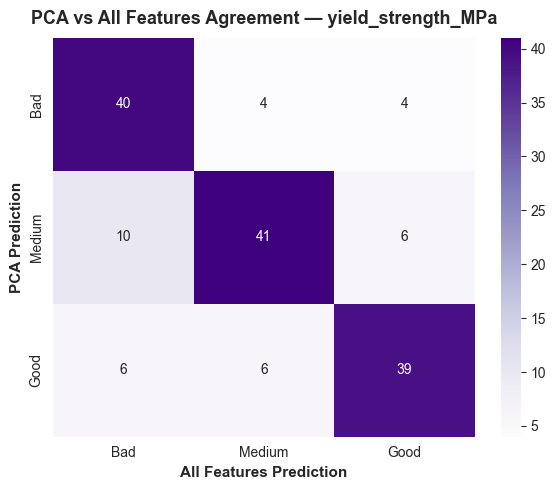

[✓] Saved: figs\compare\yield_strength_MPa_pca_vs_all_confusion.png


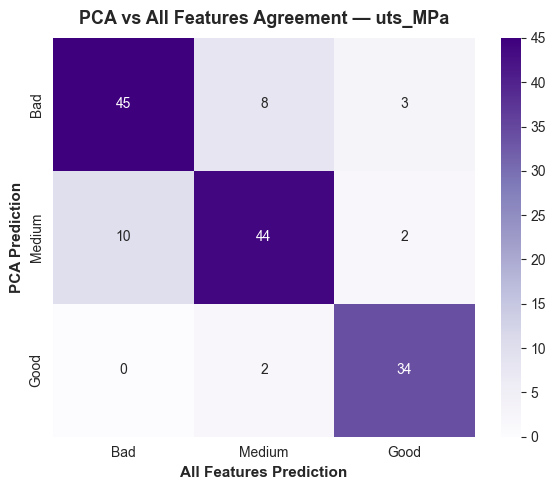

[✓] Saved: figs\compare\uts_MPa_pca_vs_all_confusion.png


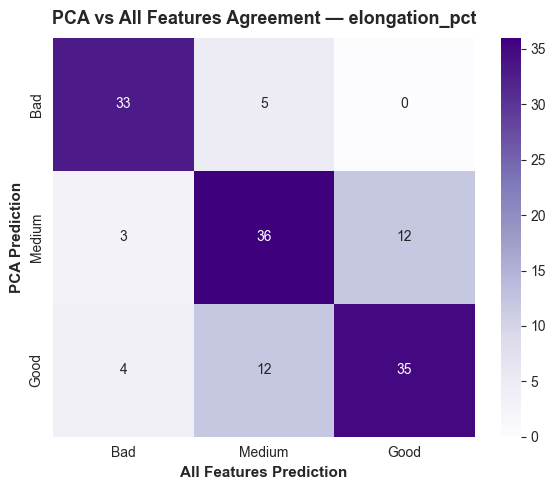

[✓] Saved: figs\compare\elongation_pct_pca_vs_all_confusion.png


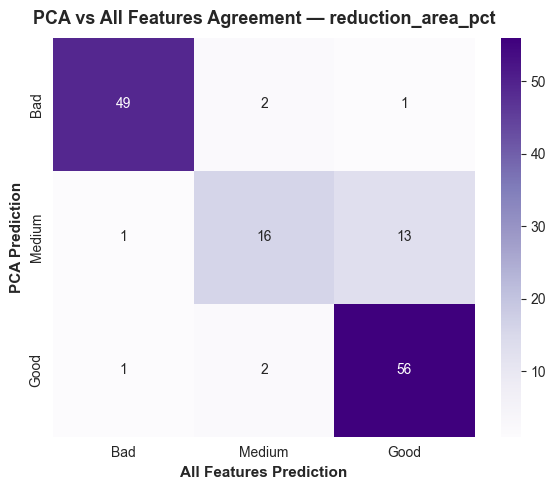

[✓] Saved: figs\compare\reduction_area_pct_pca_vs_all_confusion.png


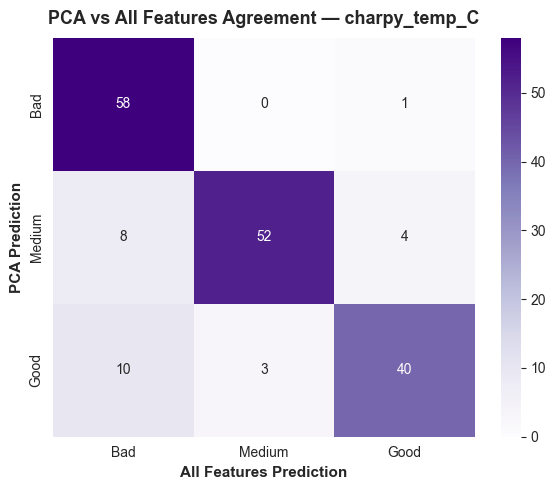

[✓] Saved: figs\compare\charpy_temp_C_pca_vs_all_confusion.png


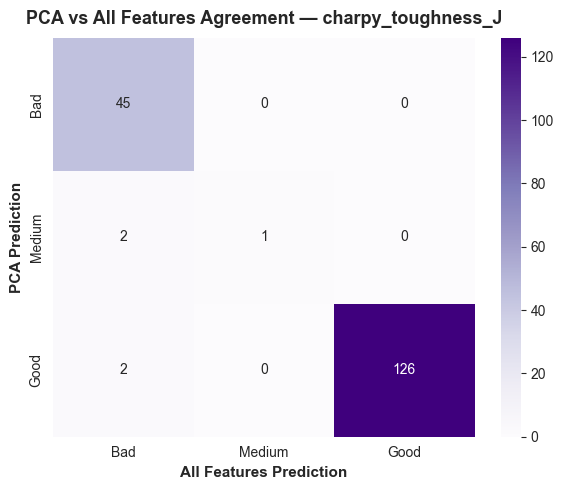

[✓] Saved: figs\compare\charpy_toughness_J_pca_vs_all_confusion.png


In [50]:
# --------------------------------------------------
# 5) matrices de confusion — sauvegarde dans weld-quality/figs/compare
# --------------------------------------------------

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Détecter la racine du projet (weld-quality)
def find_project_root(start: Path = Path.cwd()) -> Path:
    p = start.resolve()
    for _ in range(10):
        if (p / "figs").exists() or (p / "results").exists():
            return p
        p = p.parent
    return start.resolve()

PROJECT_ROOT = find_project_root()
FIGS_DIR = PROJECT_ROOT / "figs" / "compare"
FIGS_DIR.mkdir(parents=True, exist_ok=True)

print(f"[i] Saving figures to: {FIGS_DIR.resolve()}\n")

TARGETS = [
    "yield_strength_MPa",
    "uts_MPa",
    "elongation_pct",
    "reduction_area_pct",
    "charpy_temp_C",
    "charpy_toughness_J",
]

print("=== PCA vs ALL FEATURES — CONFUSION MATRICES ===\n")

for target in TARGETS:
    pca_pred_path = RESULTS_ROOT / target / "pca" / "RF_SelfTraining_predictions.csv"
    all_pred_path = RESULTS_ROOT / target / "all_features" / "RF_SelfTraining_predictions.csv"

    if not (pca_pred_path.exists() and all_pred_path.exists()):
        print(f"[!] Skipped {target} — Missing prediction files")
        continue

    y_pca = pd.read_csv(pca_pred_path)["predicted"].astype(int)
    y_all = pd.read_csv(all_pred_path)["predicted"].astype(int)

    cm = confusion_matrix(y_pca, y_all, labels=[0, 1, 2])

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Purples',
        xticklabels=['Bad', 'Medium', 'Good'],
        yticklabels=['Bad', 'Medium', 'Good']
    )
    plt.xlabel("All Features Prediction", fontsize=11, fontweight='bold')
    plt.ylabel("PCA Prediction", fontsize=11, fontweight='bold')
    plt.title(f"PCA vs All Features Agreement — {target}", fontsize=13, fontweight='bold', pad=10)
    plt.tight_layout()

    # Sauvegarde dans weld-quality/figs/compare/
    out_path = FIGS_DIR / f"{target}_pca_vs_all_confusion.png"
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"[✓] Saved: {out_path.relative_to(PROJECT_ROOT)}")

## III. Synthesis & Results Export

In [51]:
# --------------------------------------------------
# 6) Résumé global — champions, classement et moyennes
# --------------------------------------------------

best_by_target = (
    summary.sort_values(["target", "test_f1"], ascending=[True, False])
    .groupby("target")
    .head(1)
    .reset_index(drop=True)
)

display_cols = ["target", "version", "champion_model", "val_f1", "test_f1", "val_acc", "test_acc"]
print("=== BEST VERSION PER TARGET (by Test F1) ===")
print(best_by_target[display_cols].to_string(index=False))

# 1. Classement par performance
rank = (
    best_by_target
    .sort_values("test_f1", ascending=False)
    .reset_index(drop=True)
)

def nice_version(v: str) -> str:
    return "All Features" if v == "all_features" else "PCA"

name_width = max(22, rank["target"].astype(str).str.len().max())

print("\n=== TARGET RANKING (by Test F1) ===")
for i, row in rank.iterrows():
    name = str(row["target"])
    dots = "." * max(1, 2 + (name_width - len(name)))
    print(f"{i+1}. {name:<{name_width}} {dots} {row['test_f1']:.2f}% ({nice_version(row['version'])})")

# 2. Moyennes par type de features
feature_summary = (
    best_by_target.groupby("version")[["val_f1", "test_f1"]]
    .mean()
    .sort_values("test_f1", ascending=False)
)

print("\n=== AVERAGE PERFORMANCE BY FEATURE VERSION ===")
print(feature_summary.to_string(float_format="%.2f"))

# 3. Conclusion
best_version = feature_summary.index[0]
print(f"\n🏆 Global best feature version for classification: **{best_version.upper()}**")

=== BEST VERSION PER TARGET (by Test F1) ===
            target      version        champion_model  val_f1  test_f1  val_acc  test_acc
     charpy_temp_C          pca        LabelSpreading   56.51    52.66    56.82     52.84
charpy_toughness_J          pca      LabelPropagation   62.83    62.85    64.77     63.07
    elongation_pct all_features     RF + SelfTraining   68.64    68.78    68.57     68.57
reduction_area_pct all_features RF + LabelPropagation   75.46    79.23    76.60     80.14
           uts_MPa all_features          SelfTraining   77.57    80.19    77.70     79.73
yield_strength_MPa all_features          SelfTraining   71.45    72.91    71.79     73.08

=== TARGET RANKING (by Test F1) ===
1. uts_MPa                ................. 80.19% (All Features)
2. reduction_area_pct     ...... 79.23% (All Features)
3. yield_strength_MPa     ...... 72.91% (All Features)
4. elongation_pct         .......... 68.78% (All Features)
5. charpy_toughness_J     ...... 62.85% (PCA)
6. char

In [52]:
# --------------------------------------------------
# 7) Sauvegarde des synthèses
# --------------------------------------------------

comp_dir = project_root / "results" / "_comparisons"
comp_dir.mkdir(parents=True, exist_ok=True)

# Tous les champions (PCA & ALL_FEATURES) pour chaque target
summary_path = comp_dir / "pca_vs_all_features_champions.csv"
summary.to_csv(summary_path, index=False)

# La meilleure version par target (décision)
best_path = comp_dir / "best_version_per_target.csv"
best_by_target.to_csv(best_path, index=False)
print("===> Saved:")
print("   -", summary_path)
print("   -", best_path)

===> Saved:
   - C:\Users\Guillaume PORET\PycharmProjects\pythonProject\Central\weld-quality\results\_comparisons\pca_vs_all_features_champions.csv
   - C:\Users\Guillaume PORET\PycharmProjects\pythonProject\Central\weld-quality\results\_comparisons\best_version_per_target.csv


### 📊 Synthesis and Interpretation of Results

The analysis clearly highlights the **overall superiority of the “All Features” approach** across the studied targets.
On average, models trained with all available variables achieve a **mean test F1-score of 75.28%**, compared to **57.75%** for those based on PCA.

#### 🔹 Key Findings:
- The best performances are observed for **UTS (80.19%)** and **reduction_area_pct (79.23%)**, both obtained with All Features models.
- The **charpy_temp_C** and **charpy_toughness_J** targets are exceptions where PCA remains competitive or slightly better.
- The **agreement rate between PCA and All Features** predictions remains high (> 75% for most targets), indicating overall prediction consistency despite varying precision levels.

####  🔹 Interpretation:
These results suggest that dimensionality reduction through PCA does not provide a significant advantage in this context; it may even lead to a loss of information critical for class discrimination. Full-feature models better exploit the richness of mechanical descriptors, though at the cost of increased model complexity.

####  🏁 Conclusion:
- The **All Features** strategy should be preferred for most targets.
- **PCA** can still be relevant for datasets that are more correlated or noisy (such as Charpy test data).
- The collection of results and visualizations (confusion matrices, performance tables) provides a solid foundation for guiding future semi-supervised modeling strategies.